In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


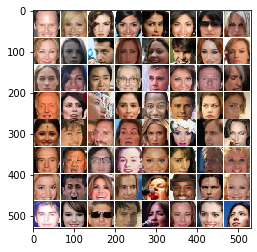

torch.Size([64, 3, 64, 64])


In [4]:
### LOAD DATA ###

dataset = 'CelebA64'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/CelebA64.h5', batch_size=64)

sample = next(iter(dataloader['train']))
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

plot_grid(sample)
print(sample_magnitudes.shape)

In [5]:
# Function to compute test images

def test_generator(model, device, testloader):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        data = data.to(device=device)
        ft = torch.rfft(data, 2, onesided=False)
        magn = torch.sqrt(torch.sum(ft**2, -1))
        ouput = model(magn)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [7]:
# Define loss

def gen_loss(gen_output, x):
    return  torch.mean(torch.abs(gen_output - x))

In [8]:
### Create new models ###

gen = models.ConvNet(imsize=imsize, outsize=imsize, s=64)

Version 0.6
Additional padding to fit 2 exp: (0, 0)
Kern size: 4096


In [9]:
# Set training parameters

history = []
opt = optim.Adam(gen.parameters(), lr=1e-3)

In [10]:
# Initial loss

gen = gen.to(device)
sample = sample.to(device)
sample_magnitudes = sample_magnitudes.to(device)

gen_out = gen(sample_magnitudes)

loss = gen_loss(gen_out, sample)

print("Generator loss:", loss.item())

Generator loss: 0.26829835772514343


/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [11]:
def train_model(gen, opt, device, loader_train, epochs=1):
    """
    Train a the conditional gan
    
    Returns: Loss history per iteration step
    """
    
    # move the model parameters to CPU/GPU
    gen = gen.to(device=device)
    
    # loss history
    history = []
    
    for e in range(epochs):
        for t, (x) in enumerate(loader_train):
            # put model to training mode
            gen.train()
            
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)
            ft =  torch.rfft(x, 2, onesided=False)
            magnitudes = torch.sqrt(torch.sum(ft**2, -1))
            
            # calculate loss and update generator
            loss = gen_loss(gen(magnitudes), x)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            history.append(loss.item())

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history[-1]))  
            
        plt.plot(history)
        plt.show()
        
        test_images, test_outputs = test_generator(gen, device, dataloader['val'])

        plot_grid(np.vstack([test_images[:16],test_outputs[:16], test_images[16:32], test_outputs[16:32]]), figsize=(8,8))
        
        mse_val = np.mean((test_outputs - test_images)**2)
        print("Mean squared dist:", mse_val)
        
        torch.save(gen.state_dict().copy(), "../cache/ConvNet64CelebA_{0:04d}_{1}_{2:.3f}.sd".format(e+1, time.strftime("%Y%m%d_%H%M%S"), mse_val))
  
    return history

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch:  1 	 step:0 	 loss: 0.04752
epoch:  1 	 step:100 	 loss: 0.04925
epoch:  1 	 step:200 	 loss: 0.04975
epoch:  1 	 step:300 	 loss: 0.04887
epoch:  1 	 step:400 	 loss: 0.05047
epoch:  1 	 step:500 	 loss: 0.05048
epoch:  1 	 step:600 	 loss: 0.04643
epoch:  1 	 step:700 	 loss: 0.0498
epoch:  1 	 step:800 	 loss: 0.04732
epoch:  1 	 step:900 	 loss: 0.04814
epoch:  1 	 step:1000 	 loss: 0.04895
epoch:  1 	 step:1100 	 loss: 0.04867
epoch:  1 	 step:1200 	 loss: 0.05172
epoch:  1 	 step:1300 	 loss: 0.04848
epoch:  1 	 step:1400 	 loss: 0.04995
epoch:  1 	 step:1500 	 loss: 0.04953
epoch:  1 	 step:1600 	 loss: 0.04691
epoch:  1 	 step:1700 	 loss: 0.05087
epoch:  1 	 step:1800 	 loss: 0.04824
epoch:  1 	 step:1900 	 loss: 0.04999
epoch:  1 	 step:2000 	 loss: 0.04967
epoch:  1 	 step:2100 	 loss: 0.04705
epoch:  1 	 step:2200 	 loss: 0.04749
epoch:  1 	 step:2300 	 loss: 0.04986
epoch:  1 	 step:2400 	 loss: 0.05189
epoch:  1 	 step:2500 	 loss: 0.04871


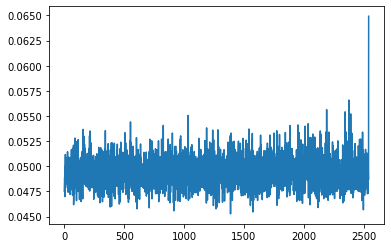

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


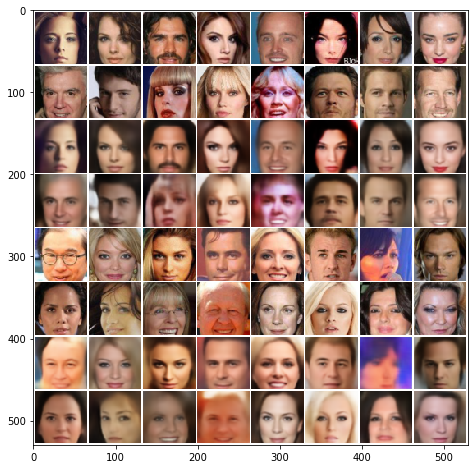

Mean squared dist: 0.011029335
epoch:  2 	 step:0 	 loss: 0.04726
epoch:  2 	 step:100 	 loss: 0.04699
epoch:  2 	 step:200 	 loss: 0.05197
epoch:  2 	 step:300 	 loss: 0.05042
epoch:  2 	 step:400 	 loss: 0.04889
epoch:  2 	 step:500 	 loss: 0.04887
epoch:  2 	 step:600 	 loss: 0.05049
epoch:  2 	 step:700 	 loss: 0.04841
epoch:  2 	 step:800 	 loss: 0.04764
epoch:  2 	 step:900 	 loss: 0.04926
epoch:  2 	 step:1000 	 loss: 0.05016
epoch:  2 	 step:1100 	 loss: 0.04862
epoch:  2 	 step:1200 	 loss: 0.04727
epoch:  2 	 step:1300 	 loss: 0.04897
epoch:  2 	 step:1400 	 loss: 0.04994
epoch:  2 	 step:1500 	 loss: 0.04903
epoch:  2 	 step:1600 	 loss: 0.04779
epoch:  2 	 step:1700 	 loss: 0.04838
epoch:  2 	 step:1800 	 loss: 0.05082


In [ ]:
### TRAIN MODEL ###

import time
num_epochs = 100

train_model(gen, opt, device, dataloader['train'], epochs=num_epochs)

gen_weights = gen.state_dict().copy()

torch.save(gen_weights, "../cache/CNN/ConvNet64CelebA_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))

In [19]:
### LOAD MODEL ####

gen = models.ConvNet(imsize=imsize, outsize=imsize, s=64)

gen.load_state_dict(torch.load("/home/shared/phase-retrieval/models/CNNnet_CelebA/ConvNet64CelebA_1_0.011.sd", map_location={'cuda:1': device.__str__()}));
gen.eval();

Version 0.6
Additional padding to fit 2 exp: (0, 0)
Kern size: 4096


In [20]:
# Calculate test predictions #

test_original, test_predicted = test_generator(gen, device, dataloader['test'])
print(test_predicted.shape)

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


(19963, 3, 64, 64)


In [21]:
### CACHE RESULTS ###

import pickle
pickle.dump(test_original, open( "/home/shared/phase-retrieval/test/CNNnet_CelebA/original_1.p", "wb" ))
pickle.dump(test_predicted, open( "/home/shared/phase-retrieval/test/CNNnet_CelebA/predicted_1.p", "wb" ) )

In [6]:
### LOAD RESULTS ###
import pickle

test_original = pickle.load(open( "/home/shared/phase-retrieval/test/CNNnet_CelebA/original_1.p", "rb" ))
test_predicted = pickle.load(open( "/home/shared/phase-retrieval/test/CNNnet_CelebA/predicted_1.p", "rb" ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


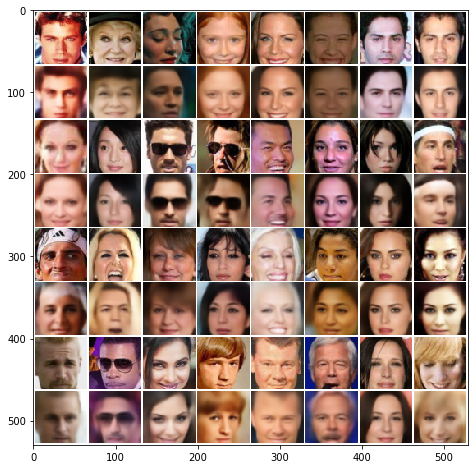

In [25]:
# Print test predictions 2 #
to_plot = np.stack([test_original[:32].reshape(4, 8*3, 64, 64), 
                    test_predicted[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
                
plot_grid(to_plot, figsize=(8,8), file="../out/e2e/celeba/ConvNet64CelebA_1.png")

In [8]:
# Benchmark test predictions #

benchmark(pred=test_predicted[:1024], true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.010676241363171357, std: 0.00969488166392528
  MAE: 0.06999879539216636, std: 0.026816683919966933
  SSIM: 0.744444458697989, std: 0.10562834143896695
  Sharpness: 0.04350162341054161, std: 0.011801090820848617
  PhCo-MSE: 0.012141495408286573, std: 0.015259264428607406
  PhCo-MAE: 0.07320700858326745, std: 0.0341168238524149
  PhCo-SSIM: 0.7311438653264029, std: 0.12721411603103913
  CroCo-MSE: 0.010174567126000511, std: 0.00833929561024899
  CroCo-MAE: 0.06895373488441692, std: 0.025092993561603546
  CroCo-SSIM: 0.7444183431448197, std: 0.10701046175421697

Magnitude error:
  MSE Magnitude: 16.01123019021062, std: 12.721748139133727

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.01068 | 0.07000 | 0.7444 | 0.04350 | 0.01214 | 0.07321 | 0.7311 | 0.01017 | 0.06895 | 0.7444 | 16.01 |


## Evaluation for different CNN  (1024 samples)

| Nr | Loss | Size | epochs | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | MAE | 64 | 100 | 0.01068 | 0.07000 | 0.7444 | 0.04350 | 0.01214 | 0.07321 | 0.7311 | 0.01017 | 0.06895 | 0.7444 | 16.01 |


In [11]:
### Exchange original phase with FC Net computed phase ###

orig_fft = np.fft.fft2(test_original[:1024])
orig_magn = np.abs(orig_fft)
orig_phase = np.angle(orig_fft)
test_fft = np.fft.fft2(test_predicted[:1024])
test_magn = np.abs(test_fft)
test_Phase = np.angle(test_fft)

Combined = orig_magn * np.exp(1j * test_Phase)
combined = np.fft.ifft2(Combined)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


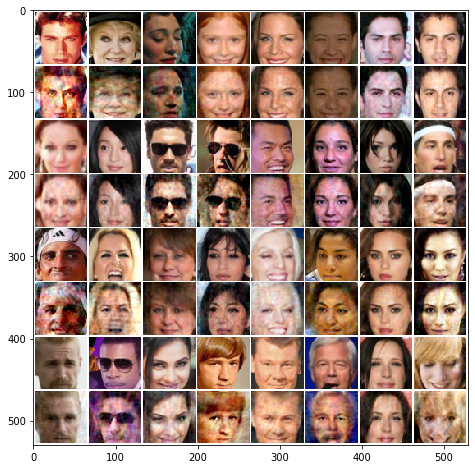

In [28]:
# Print test predictions with original magnitue #
to_plot = np.stack([test_original[:32].reshape(4, 8*3, 64, 64), 
                    np.real(combined)[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
                
plot_grid(to_plot, figsize=(8,8), file="/home/shared/phase-retrieval/out/CNNnet_CelebA/ConvNet64CelebA_1_origMagn.png")


In [12]:
# Benchmark predicted phase with original magnitude #

benchmark(pred=combined, true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.011180435707738171, std: 0.012133041205397752
  MAE: 0.07289155477110923, std: 0.03153752702599478


/home/alobe101/.local/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


  SSIM: 0.7121930932522547, std: 0.13196750702572177
  Sharpness: 0.047886513820252004, std: 0.014834808376738258
  PhCo-MSE: 0.012845808505219814, std: 0.01796122545601521
  PhCo-MAE: 0.0763318034060086, std: 0.03875893426601059
  PhCo-SSIM: 0.6989345110692475, std: 0.1510311303243624
  CroCo-MSE: 0.010496080326196023, std: 0.009819891105027997
  CroCo-MAE: 0.07158500305523928, std: 0.02889758269501745
  CroCo-SSIM: 0.7134934311491077, std: 0.1307246822590622

Magnitude error:
  MSE Magnitude: 3.277981615534001e-29, std: 1.0091215532111709e-29

Image constraints:
  Imag part = -1.3765038848128987e-35 - should be very close to 0
  Real part is in [-0.79, 1.69] - should be in [0, 1]

Markdown table values:
 0.01118 | 0.07289 | 0.7122 | 0.04789 | 0.01285 | 0.07633 | 0.6989 | 0.01050 | 0.07159 | 0.7135 | 0.00000000000000000000000000003278 |


## Evaluation for different CNN models with original magnitudes (first 1024 test samples)

| Loss | Size | epochs | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn | \[min,max\]
| --- | --- | --- | --- | --- | --- | --- |
| MAE | 64 | 100 | 0.01118 | 0.07289 | 0.7122 | 0.04789 | 0.01285 | 0.07633 | 0.6989 | 0.01050 | 0.07159 | 0.7135 | 0 | \[-0.79, 1.69\]